In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts

testingscripts.realtimeFFT_validator() # Should return True

True

In [2]:
def rhotosigma(rhoG,rhoD,M,dt,t,g,beta,kappa=1,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    eta = np.pi/(M*dt)*(0.001)
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fermidirac(beta*omega),M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fermidirac(-1.*beta*omega),M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fermidirac(beta*(omega)),M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fermidirac(-1.*beta*omega),M,dt)
    rhoBpp = (1/np.pi)*freq2time(rhoD * boseeinstein(beta*(omega+eta)),M,dt)
    rhoBpm = (1/np.pi)*freq2time(rhoD * boseeinstein(-1.*beta*(omega+eta)),M,dt)
    
    argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    #argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.heaviside(t,1)
    Sigma = 1j*(g**2)*kappa * time2freq(argSigma,M,dt)
    
    argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    #argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.heaviside(t,1)
    Pi = 2*1j*(g**2) * time2freq(argPi,M,dt)
    
    return [Sigma, Pi]

In [3]:
g = 0.5
mu = 0.
#r = 0.001
#r = 0. 
r = 1.

beta = 50.

M = int(2**18) #number of points in the grid
T = 2**12 #upper cut-off for the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
#eta = 1.1011011101111011111 * dw * 0.1
#eta = dw*11.
eta = dw*1.000001
#eta = dw*0.01

omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-1
print("omega max = ", omega[-1], "dw = ", dw )
print("dt = ", dt)

delta = 0.420374134464041
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")

omega max =  201.06116283935282 dw =  0.0007669903939428206
dt =  0.015625


In [4]:
def RE_YSYK_iterator(GRomega,DRomega,g,beta,verbose=True):
    itern = 0
    omegar2 = ret_omegar2(g,beta)
    diff = 1 
    diffG,diffD = (0.5,0.5)
    xG,xD = (0.5,0.5)

    while (diff>err and itern<100): 
        itern += 1 
        diffoldG,diffoldD = (diffG,diffD)
        GRoldomega,DRoldomega = (1.0*GRomega, 1.0*DRomega)

        rhoG = -1.0*np.imag(GRomega)
        rhoD = -1.0*np.imag(DRomega)

        SigmaOmega,PiOmega = rhotosigma(rhoG,rhoD,M,dt,t,g,beta,kappa=1,delta=eta)
        #PiOmega[M] = 1.0*r - omegar2

    #     if itern < 30 : 
    #         PiOmega[M] = 1.0*r - omegar2

        GRomega = 1.0*xG/(omega + 1j*eta + mu - SigmaOmega) + (1-xG)*GRoldomega
        DRomega = 1.0*xD/(-1.0*(omega+1j*eta)**2 + r - PiOmega) + (1-xD)*DRoldomega

        GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
        DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)
        #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
        #DRt = DRt - np.imag(DRt) # make D(t) purely real
        #GRt[:M] = 0
        #DRt[:M] = 0
        GRt[M] = -1j
        DRt[M] = 0

        if itern > 40 :
            #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
            #DRt = DRt - np.imag(DRt) # make D(t) purely real
            GRt[:M] = 0
            DRt[:M] = 0
            #GRt[M] = -1j
            #DRt[M] = 0

        GRomega = time2freq(GRt,M,dt)
        DRomega = time2freq(DRt,M,dt)

        diffG = np. sqrt(np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
        diffD = np. sqrt(np.sum((np.abs(DRomega-DRoldomega))**2))
        #diff = np.max([diffG,diffD])
        diff = 0.5*(diffG+diffD)
        diffG,diffD = diff,diff

        if diffG>diffoldG:
            xG/=2.
        if diffD>diffoldD:
            xD/=2.

        if verbose:
            print("itern = ",itern, " , diff = ", diffG, diffD, " , x = ", xG, xD, end = '\r')
    
    return (GRomega,DRomega)




In [5]:
#GRomega = (-1j)*np.ones(2*M)
#GRomega = time2freq((-1j)*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
#GRomega = time2freq(GRconf(t+1j*delta,J = Jot,beta = beta),M,dt)
GRomega = 1/(omega + 1j*eta + mu)
#DRomega = 1/(-1.0*(omega + 1j*eta)**2 + r)
#DRomega = -1.0*np.ones(2*M)
#DRomega = time2freq(-1.0*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
DRomega = DconfImag(-1j*(omega),g,beta)
#GRomega = GconfImag(-1j*(omega+1j*eta),g,beta)


GRomega, DRomega = RE_YSYK_iterator(GRomega,DRomega,g,beta,verbose=True) #updates in place

GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)

/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))
/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: overflow encountered in exp
  return (1.0/(np.exp(arg)-1))


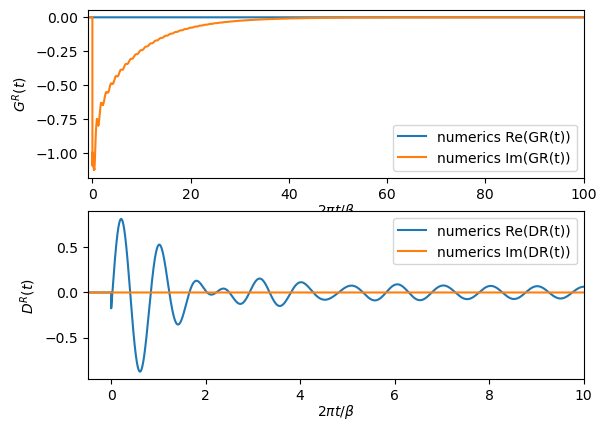

In [6]:
fig, ax = plt.subplots(2)

ax[0].plot(2*np.pi*t/beta, np.real(GRt), label = r'numerics Re(GR(t))')
ax[0].plot(2*np.pi*t/beta, np.imag(GRt), label = r'numerics Im(GR(t))')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-1,100)
ax[0].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[0].set_ylabel(r'${G^R(t)}$')
ax[0].legend()

ax[1].plot(2*np.pi*t/beta, np.real(DRt),'-',label = 'numerics Re(DR(t))')
ax[1].plot(2*np.pi*t/beta, np.imag(DRt), label = 'numerics Im(DR(t))')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[1].set_ylabel(r'${D^R(t)}$')
#ax[1].set_xlim(0,beta/(2*np.pi))
ax[1].set_xlim(-0.5,10)
ax[1].legend()


In [7]:
np.exp(-np.pi)

0.04321391826377226